# ETTm1에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기
* 이전과 다르게 sequence_length를 `4(15minutes*4)*24(24hours)*30(30days) = 2880` 즉 30일을 바라봄

In [2]:
hour_data = pd.read_csv('../../GeneralData/ETTh1.csv')
hour_data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


* minute data를 hour data와 비교했을때 누적이아닌 단순히 분단위로 추적했을 뿐이다.

In [3]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [4]:
data = pd.read_csv('../../GeneralData/ETTm1.csv')
sequence_length = 4*24*30 # 4*24*30 
pred_len = 1

## 2. Sequence중에 빈 시간이 없나 Check

In [5]:
import datetime as dt

In [6]:
data['date'] = pd.to_datetime(data['date'])
for i in range(data.shape[0]-1):
    if data['date'].iloc[i]+dt.timedelta(minutes = 15) == data['date'].iloc[i+1]: continue        
    else: print(i)

### &rightarrow; 빈시간 없음

In [7]:
data = data[['OT']]

In [8]:
data

,OT
0,30.531000
1,30.459999
2,30.038000
3,27.013000
4,27.787001
...,...
69675,9.567000
69676,9.567000
69677,9.426000
69678,9.426000


<AxesSubplot: >

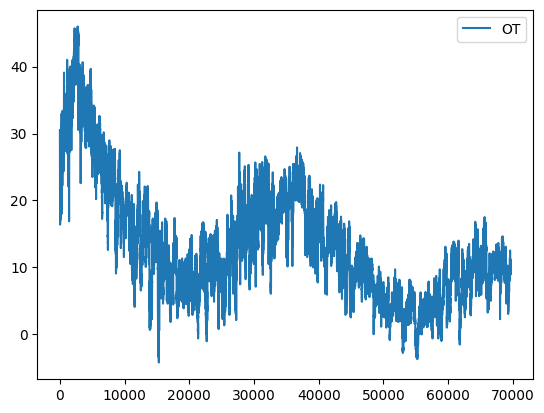

In [9]:
data.plot()

In [10]:
from torch import FloatTensor as FloatTensor

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [13]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [14]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,train_index): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)    
        
        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        seasonal_init,trend_init = self.decomposition(x)
                
        seasonal_output = self.Linear_Seasonal(seasonal_init[:,:,self.train_index])    
        trend_output = self.Linear_Trend(trend_init[:,:,self.train_index])
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [15]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [16]:
seed = 42

In [17]:
device = torch.device("cuda:0")

# 3. Train-Validation set으로 쪼개기

In [18]:
data

,OT
0,30.531000
1,30.459999
2,30.038000
3,27.013000
4,27.787001
...,...
69675,9.567000
69676,9.567000
69677,9.426000
69678,9.426000


* 69680개 중 일주일치 데이터인 672개의 데이터를 Test Set
* 69008개 중 0.2의 비율인 13802개는 validation set
* 69008개 중 0.8의 비율인 55206개는 train set

In [19]:
val_num = 13802

In [20]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_730620/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [21]:
next(iter(validation))[0].size()

torch.Size([64, 1, 2880])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [22]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [23]:
import copy

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 1407.762
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 1354.919
changed
Epoch [41]/[100] running accumulative loss across all batches: 1860.308
Epoch [61]/[100] running accumulative loss across all batches: 1914.147
Epoch [81]/[100] running accumulative loss across all batches: 2289.162


### validation set에 대해서 attribution 구하기

In [25]:
n = len(validation)
n

171

In [26]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [27]:
len(nt_ig_attr_score)

2880

<AxesSubplot: >

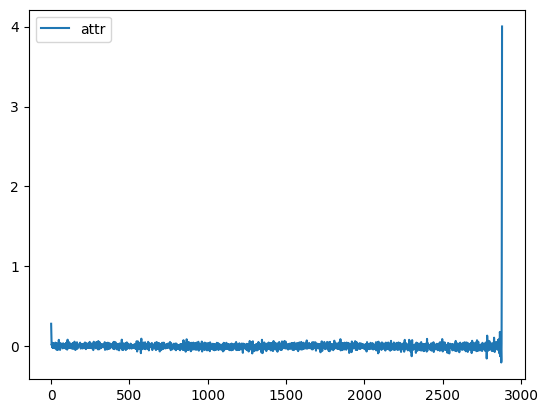

In [28]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,2.777189
1,1.645291
2,0.193005
3,0.150838
4,0.229826
...,...
2875,-1.742132
2876,0.331456
2877,8.983487
2878,31.073263


#### train_index구하기

In [30]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [31]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


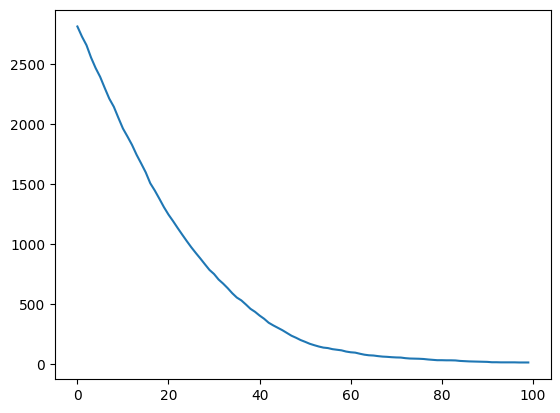

In [32]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [33]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[2.2510, 2.2510, 2.3920,  ..., 4.2910, 4.4320, 4.2210]],

        [[2.2510, 2.3920, 2.6030,  ..., 4.4320, 4.2210, 4.5020]],

        [[2.3920, 2.6030, 2.6730,  ..., 4.2210, 4.5020, 4.5020]],

        ...,

        [[4.0800, 3.9390, 4.0800,  ..., 5.7680, 5.9790, 5.7680]],

        [[3.9390, 4.0800, 3.9390,  ..., 5.9790, 5.7680, 5.6280]],

        [[4.0800, 3.9390, 3.5880,  ..., 5.7680, 5.6280, 5.4870]]],
       device='cuda:0') tensor([[[4.5020]],

        [[4.5020]],

        [[4.6430]],

        [[4.4320]],

        [[4.9950]],

        [[5.1350]],

        [[5.2060]],

        [[5.8390]],

        [[5.6980]],

        [[5.8390]],

        [[5.6980]],

        [[5.9090]],

        [[6.3310]],

        [[6.5420]],

        [[6.8240]],

        [[7.3160]],

        [[7.4570]],

        [[7.3160]],

        [[6.9640]],

        [[7.1750]],

        [[7.1750]],

        [[7.6680]],

        [[7.5970]],

        [[7.6680]],

        [[7.5270]],

        [[7.3160]],

        [[8.02

tensor([[[2.3210, 2.5320, 3.0250,  ..., 3.2360, 3.5170, 2.8140]],

        [[2.5320, 3.0250, 1.6880,  ..., 3.5170, 2.8140, 3.0950]],

        [[3.0250, 1.6880, 2.3210,  ..., 2.8140, 3.0950, 2.9550]],

        ...,

        [[2.6030, 2.3920, 2.8840,  ..., 3.9390, 4.2210, 4.1500]],

        [[2.3920, 2.8840, 3.0950,  ..., 4.2210, 4.1500, 3.6580]],

        [[2.8840, 3.0950, 3.3770,  ..., 4.1500, 3.6580, 4.0100]]],
       device='cuda:0') tensor([[[3.0950]],

        [[2.9550]],

        [[3.0950]],

        [[2.6030]],

        [[2.8840]],

        [[2.3210]],

        [[2.4620]],

        [[2.1810]],

        [[1.8990]],

        [[2.7440]],

        [[2.5320]],

        [[3.2360]],

        [[3.4470]],

        [[3.6580]],

        [[2.8840]],

        [[2.3920]],

        [[2.7440]],

        [[2.8840]],

        [[2.5320]],

        [[2.5320]],

        [[3.0250]],

        [[3.2360]],

        [[2.6030]],

        [[3.2360]],

        [[3.1660]],

        [[3.4470]],

        [[3.37

       device='cuda:0') tensor([[[4.5020]],

        [[4.7130]],

        [[4.5020]],

        [[4.2910]],

        [[4.5730]],

        [[4.5020]],

        [[4.2210]],

        [[4.1500]],

        [[4.0800]],

        [[4.2210]],

        [[4.1500]],

        [[3.8690]],

        [[3.7280]],

        [[4.2910]],

        [[4.2210]],

        [[4.2910]],

        [[4.1500]],

        [[3.9390]],

        [[4.2210]],

        [[4.1500]],

        [[4.3620]],

        [[4.1500]],

        [[4.1500]],

        [[3.9390]],

        [[3.9390]],

        [[3.9390]],

        [[3.7280]],

        [[3.7280]],

        [[4.2210]],

        [[4.5730]],

        [[4.9950]],

        [[5.3460]],

        [[5.2060]],

        [[4.9950]],

        [[4.2210]],

        [[4.1500]],

        [[4.5020]],

        [[4.5730]],

        [[3.7280]],

        [[3.4470]],

        [[4.5020]],

        [[4.8540]],

        [[5.3460]],

        [[4.7130]],

        [[4.0800]],

        [[3.8690]],

        [[

       device='cuda:0') tensor([[[6.4720]],

        [[6.5420]],

        [[6.2610]],

        [[5.9090]],

        [[5.5570]],

        [[5.8390]],

        [[6.9640]],

        [[6.7530]],

        [[6.3310]],

        [[6.2610]],

        [[6.4720]],

        [[6.6130]],

        [[7.0350]],

        [[7.1050]],

        [[7.1050]],

        [[7.0350]],

        [[7.3860]],

        [[7.5270]],

        [[7.1750]],

        [[7.6680]],

        [[7.1750]],

        [[8.0200]],

        [[8.0200]],

        [[7.8090]],

        [[8.1600]],

        [[7.8790]],

        [[8.1600]],

        [[8.4420]],

        [[8.2310]],

        [[8.0900]],

        [[8.6530]],

        [[8.1600]],

        [[8.3010]],

        [[7.9490]],

        [[8.2310]],

        [[8.3010]],

        [[8.3710]],

        [[8.3010]],

        [[7.6680]],

        [[8.0900]],

        [[8.5120]],

        [[8.5820]],

        [[8.4420]],

        [[8.0200]],

        [[7.9490]],

        [[8.0900]],

        [[

tensor([[[ 5.9090,  6.0500,  5.9090,  ..., 11.2560,  8.4420,  8.5820]],

        [[ 6.0500,  5.9090,  5.9090,  ...,  8.4420,  8.5820,  8.0900]],

        [[ 5.9090,  5.9090,  5.8390,  ...,  8.5820,  8.0900,  8.7930]],

        ...,

        [[ 4.8540,  4.6430,  4.7840,  ..., 10.1300, 10.1300,  9.9890]],

        [[ 4.6430,  4.7840,  4.8540,  ..., 10.1300,  9.9890, 10.4110]],

        [[ 4.7840,  4.8540,  4.8540,  ...,  9.9890, 10.4110, 10.3410]]],
       device='cuda:0') tensor([[[ 8.0900]],

        [[ 8.7930]],

        [[ 8.3010]],

        [[ 7.8790]],

        [[ 8.1600]],

        [[ 8.6530]],

        [[ 9.7780]],

        [[10.3410]],

        [[10.4110]],

        [[10.6930]],

        [[10.5520]],

        [[11.2560]],

        [[11.4670]],

        [[11.1150]],

        [[10.9040]],

        [[11.0440]],

        [[10.6930]],

        [[10.8330]],

        [[11.0440]],

        [[11.1850]],

        [[10.9740]],

        [[10.6930]],

        [[10.6220]],

        [[10.7630]

tensor([[[12.5220, 12.8030, 12.4510,  ..., 11.7480, 11.6070, 11.6780]],

        [[12.8030, 12.4510, 12.6620,  ..., 11.6070, 11.6780, 11.5370]],

        [[12.4510, 12.6620, 13.2250,  ..., 11.6780, 11.5370, 11.6780]],

        ...,

        [[12.8740, 12.9440, 13.0140,  ...,  9.9890,  9.9190, 10.2000]],

        [[12.9440, 13.0140, 12.8740,  ...,  9.9190, 10.2000, 10.4820]],

        [[13.0140, 12.8740, 12.5920,  ..., 10.2000, 10.4820, 10.5520]]],
       device='cuda:0') tensor([[[11.5370]],

        [[11.6780]],

        [[11.3260]],

        [[11.3960]],

        [[11.3260]],

        [[11.2560]],

        [[11.6070]],

        [[11.4670]],

        [[11.1150]],

        [[10.7630]],

        [[10.9040]],

        [[10.8330]],

        [[11.0440]],

        [[10.9040]],

        [[10.7630]],

        [[10.8330]],

        [[10.9040]],

        [[10.6930]],

        [[10.3410]],

        [[10.4820]],

        [[ 9.4260]],

        [[ 9.5670]],

        [[ 9.6380]],

        [[ 9.7780]

tensor([[[15.8980, 15.5470, 16.1090,  ...,  9.4260,  9.4260,  9.5670]],

        [[15.5470, 16.1090, 15.8980,  ...,  9.4260,  9.5670,  9.2860]],

        [[16.1090, 15.8980, 16.3910,  ...,  9.5670,  9.2860,  9.3560]],

        ...,

        [[13.8580, 13.5070, 13.7180,  ..., 10.1300, 10.2000, 10.5520]],

        [[13.5070, 13.7180, 13.6470,  ..., 10.2000, 10.5520, 10.6930]],

        [[13.7180, 13.6470, 14.0690,  ..., 10.5520, 10.6930, 10.7630]]],
       device='cuda:0') tensor([[[ 9.2860]],

        [[ 9.3560]],

        [[ 9.2150]],

        [[ 9.1450]],

        [[ 9.2150]],

        [[ 9.2150]],

        [[ 9.2860]],

        [[ 9.2860]],

        [[ 9.1450]],

        [[ 9.0750]],

        [[ 9.0040]],

        [[ 8.7230]],

        [[ 8.9340]],

        [[ 8.8640]],

        [[ 8.8640]],

        [[ 8.5120]],

        [[ 8.5820]],

        [[ 8.6530]],

        [[ 8.5120]],

        [[ 8.5820]],

        [[ 8.4420]],

        [[ 8.4420]],

        [[ 8.5120]],

        [[ 8.5120]

In [34]:
val_x

tensor([[[8.6530, 8.6530, 8.5120,  ..., 9.4970, 9.3560, 9.0750]],

        [[8.6530, 8.5120, 8.5820,  ..., 9.3560, 9.0750, 9.2150]],

        [[8.5120, 8.5820, 8.5120,  ..., 9.0750, 9.2150, 9.5670]],

        ...,

        [[8.0900, 7.6680, 8.3710,  ..., 8.5820, 8.7230, 8.7230]],

        [[7.6680, 8.3710, 7.4570,  ..., 8.7230, 8.7230, 9.0040]],

        [[8.3710, 7.4570, 7.4570,  ..., 8.7230, 9.0040, 9.2150]]],
       device='cuda:0')

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:2207.653252720905
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:2076.106189756674
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:1897.250610963412
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:1762.696825220874
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:1140.356763508216
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:1514.8832683728842
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:1142.1933125781197
changed
changed
changed
changed
changed
ch

changed
33번째 모델 Training 완료 마지막 Epoch loss:55.582593913814705
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
34번째 모델 Training 완료 마지막 Epoch loss:78.18746833856834
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chang

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
44번째 모델 Training 완료 마지막 Epoch loss:23.145424951258008
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
45번째 모델 Training 완료 마지막 Epoch loss:22.69020500304245
chang

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
54번째 모델 Training 완료 마지막 Epoch loss:20.30161823723612
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
64번째 모델 Training 완료 마지막 Epoch loss:19.690004904353067
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
74번째 모델 Training 완료 마지막 Epoch loss:19.425620751798753
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


In [49]:
val_y # 다음 예측 타겟값

tensor([[[9.2150]],

        [[9.5670]],

        [[9.4970]],

        [[9.7080]],

        [[9.5670]],

        [[9.4260]],

        [[9.2150]],

        [[9.3560]],

        [[9.2860]],

        [[9.2150]],

        [[9.1450]],

        [[9.0040]],

        [[9.1450]],

        [[9.2150]],

        [[9.0750]],

        [[8.8640]],

        [[8.7230]],

        [[8.6530]],

        [[8.8640]],

        [[8.5120]],

        [[8.5120]],

        [[8.7230]],

        [[8.3710]],

        [[8.3710]],

        [[8.3710]],

        [[8.3710]],

        [[8.3710]],

        [[8.3710]],

        [[8.4420]],

        [[8.3710]],

        [[8.5120]],

        [[8.5820]],

        [[8.7230]],

        [[8.5820]],

        [[8.7230]],

        [[8.5820]],

        [[8.7230]],

        [[8.7230]],

        [[9.0040]],

        [[9.2150]],

        [[9.0750]]], device='cuda:0')

In [50]:
val_x # 예측 하는 값

tensor([[[8.6530, 8.6530, 8.5120,  ..., 9.4970, 9.3560, 9.0750]],

        [[8.6530, 8.5120, 8.5820,  ..., 9.3560, 9.0750, 9.2150]],

        [[8.5120, 8.5820, 8.5120,  ..., 9.0750, 9.2150, 9.5670]],

        ...,

        [[8.0900, 7.6680, 8.3710,  ..., 8.5820, 8.7230, 8.7230]],

        [[7.6680, 8.3710, 7.4570,  ..., 8.7230, 8.7230, 9.0040]],

        [[8.3710, 7.4570, 7.4570,  ..., 8.7230, 9.0040, 9.2150]]],
       device='cuda:0')

In [51]:
val_x.size()

torch.Size([41, 1, 2880])

         out
91  0.112377
92  0.112377


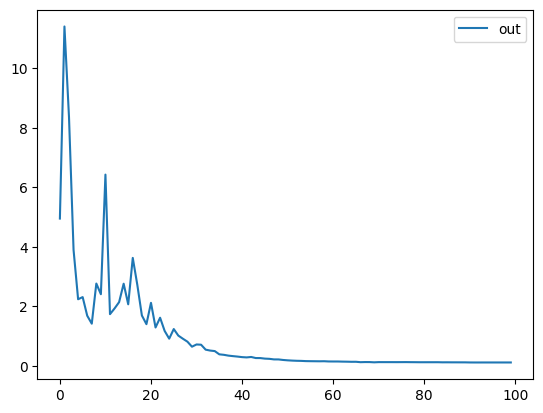

In [44]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
91  0.224483
92  0.224483


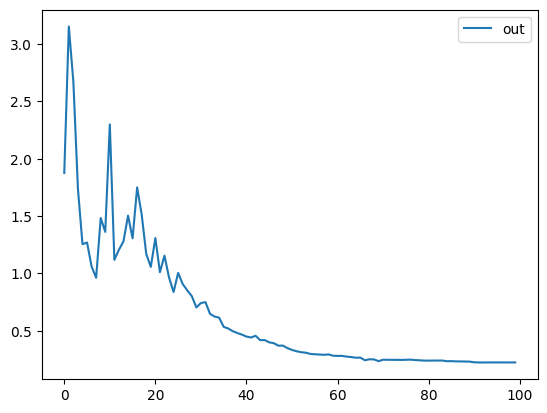

In [45]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
91  4.257053
92  4.257053


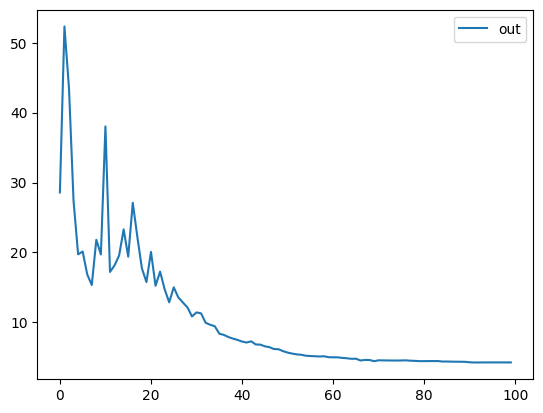

In [46]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
91  0.335227
92  0.335227


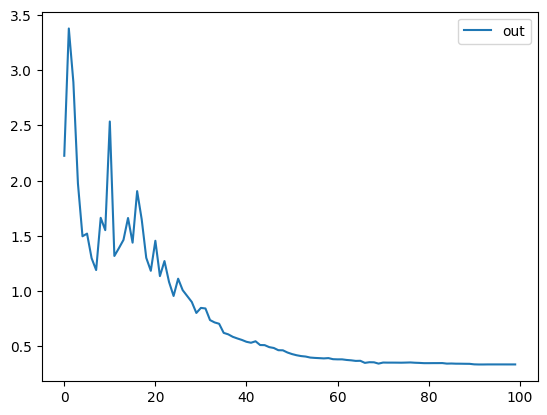

In [47]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [48]:
attr_df.describe()

,attr
count,2.880000e+03
mean,4.934325e-18
std,1.000174e+00
min,-2.042046e+00
25%,-2.080523e-01
50%,-2.728399e-02
75%,1.556568e-01
max,3.977623e+01
